#  **ICT303 - Assignment 2**

**Your name: Anson Ting Lik Yuan**

**Student ID: 34212178** 

**Email: ansontly00@gmail.com** 

In this assignment, you will build a deep learning model for identifying $120$ different breeds of dogs. Similar to the previous assignment, you will use real images from the [Kaggle competition](https://www.kaggle.com/c/dog-breed-identification). 

In this assignment, your are required to use a ResNet network. You can use ResNet implementation provided in PyTorch. Note however  that there are many versions of ResNet (they differ in terms of number of layers). Your task is to find the best configuration that gives the best performance. 

The rule is similar to the previous assignment:

1. Develop a better model to reduce the recognition error.  
2. Submit your results to Kaggle and take a sceenshot of your score. Then insert here the screenshot of your result. 

It is important that you start as earlier as possible. Tuning hyper-parameters takes time, and Kaggle limits the number of submissions per day.

The top 3 students in the Kaggle ranking will be invited for a coffee!

chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://c.d2l.ai/berkeley-stat-157/homeworks/homework7.pdf

## **1. Obtaining and Organizing the Data Set**

The competition data is divided into a training set and testing set:
- The training set contains $10,222$ color images.
- The testing set contains 10,357 color images. 

The images in both sets are in JPEG format. Each image contains three channels (R, G and B). The images have  different heights and widths.

There are $120$ breeds of dogs in the training set, e.g., *Labradors, Poodles, Dachshunds,
Samoyeds, Huskies, Chihuahuas, and Yorkshire Terriers*.

In [ ]:
# Connect google drive
# Force_remount - force refresh
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Libraries
import cv2
import os
from tqdm import tqdm
import numpy as np 
import pandas as pd
import zipfile
# For this project, I've decided to use Resnet50V2, which is 50 layers deeper than default resnet.
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization

### **1.1. Downloading the Data Set**

After logging in to Kaggle, click on the “Data” tab on the dog breed identification competition webpage and download:
- the training data set `train.zip` and their corresponing labels `label.csv.zip`,
- the testing data set `test.zip`, 

After downloading the files, place them in the three paths below:
- kaggle_dog/train.zip
- kaggle_dog/test.zip
- kaggle_dog/labels.csv.zip

Run the code below to extract the data. 

In [ ]:
dataDir = '/content/drive/MyDrive/ICT 303 /Assignment_2/kaggle_dog'

# Removed labels.csv.zip, uploaded it as csv file instead of zip.
zipfiles = ['train.zip','test.zip']
for f in zipfiles:
  with zipfile.ZipFile(dataDir + '/' + f, 'r') as z:
    z.extractall(dataDir)

### **1.2. Organizing the Data Set**

Next, we define the reorg_train_valid function to split the validation set from the original Kaggle competition training set. The parameter valid_ratio in this function is the ratio of the number of examples of each dog breeds in the validation set to the number of examples of the
breed with the least examples (66) in the original training set. 

After organizing the data, images of the same breed will be placed in the same folder so that we can read them later.

The `reorg_dog_data` function below is used to read the training data labels, segment the validation set, and organize the training set.

During actual training and testing, we would use the entire Kaggle Competition data set and call the reorg_dog_data function to organize the data set. Likewise, we would need to set the batchSize to a larger integer, such as 128.

In [ ]:
#read the csv file
dfLabels = pd.read_csv("/content/drive/MyDrive/ICT 303 /Assignment_2/kaggle_dog/labels.csv")
#store training and testing images folder location
trainData = '/content/drive/MyDrive/ICT 303 /Assignment_2/kaggle_dog/train/'
testData = '/content/drive/MyDrive/ICT 303 /Assignment_2/kaggle_dog/test/'

In [ ]:
print("Total number of unique Dog Breeds :",len(dfLabels.breed.unique()))
#dfLabels.breed

Total number of unique Dog Breeds : 120


In [ ]:
# Number of breeds

numBreeds = 120
# Image size
imageSize = 224
# Batch size for trading
# I've made a mistake here, should've set the batchSize to 128
batchSize = 64
# Encoder
encoder = LabelEncoder()

In [ ]:
# Using all dog breeds
breedDict = list(dfLabels['breed'].value_counts().keys()) 
newList = sorted(breedDict,reverse=True)[:numBreeds*2+1:2]
dfLabels = dfLabels.query('breed in @newList')

In [ ]:
dfLabels['img_file'] = dfLabels['id'].apply(lambda x: x + ".jpg")

In [ ]:
# Creating training inputs
trainX = np.zeros((len(dfLabels), imageSize, imageSize, 3), dtype='float32')

for i, imgId in enumerate(dfLabels['img_file']):
  img = cv2.resize(cv2.imread(trainData+imgId,cv2.IMREAD_COLOR),((imageSize,imageSize)))
  imgArray = preprocess_input(np.expand_dims(np.array(img[...,::-1].astype(np.float32)).copy(), axis=0))
  trainX[i] = imgArray

In [ ]:
#convert into numerical format
trainY = encoder.fit_transform(dfLabels["breed"].values)

In [ ]:
xTrain, xTest, yTrain, yTest = train_test_split(trainX,trainY,test_size=0.2,random_state=42)

## **2. Image Augmentation**

Sometimes, when we do not have enough images to train our deep learning model, we data augmentation to simulate new data. For example, in the case of images, assume we only have $10$ images per class. We can create more instance by applying transformations to these images. For example, if the image is of a standin dog, we can rotate it $90$ and $180$ degrees to create two additional instances of the same dog. We can also scale it, etc.

Here are some more image augmentation operations that might be useful.

Start by training your model on the data set, the way it is provided. Then, think of the types of transformations you can apply to the training images to improve the performance. 

You can find more about how to apply transformations to images in this [link](https://pytorch.org/vision/stable/transforms.html).

In [ ]:
# ImageDataGenerator class
trainDatagen = ImageDataGenerator(rotation_range=45,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.25,horizontal_flip=True,fill_mode='nearest')

# Images training sets
trainGenerator = train_datagen.flow(x_train, y_train, batchSize=batchSize)

testGatagen = ImageDataGenerator()
 
testGenerator = testGatagen.flow(x_test, y_test, batchSize=batchSize)

In [ ]:
#building the model using ResNet50V2
resnet = ResNet50V2(input_shape = [imageSize,imageSize,3], weights='imagenet', include_top=False)
for layer in resnet.layers:
    layer.trainable = False

# Configures layers
x = resnet.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

94668760/94668760 [==============================] - 0s 0us/step


## **3. Loading (Reading) the Data Set**

In [ ]:
predictions = Dense(numBreeds, activation='softmax')(x)
 
model = Model(inputs=resnet.input, outputs=predictions)
#model.summary()

In [ ]:
# Define number of epochs and learning rate
epochs = 400
lr = 0.0001
 
#using RMSprop optimizer
optimizer = RMSprop(learning_rate=lr,rho=0.9)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=["accuracy"])
 
#train the model
hist = model.fit(train_generator,steps_per_epoch= x_train.shape[0] // batchSize,epochs= epochs,validation_data= test_generator,validation_steps= x_test.shape[0] // batchSize)
 
#Save the model for prediction
model.save("/content/drive/MyDrive/ICT 303 /Assignment_2/models/500_epochs_model")

Epoch 1/400
64/64 [==============================] - 45s 656ms/step - loss: 0.5452 - accuracy: 0.8265 - val_loss: 0.6039 - val_accuracy: 0.8135
Epoch 2/400
64/64 [==============================] - 41s 635ms/step - loss: 0.5327 - accuracy: 0.8354 - val_loss: 0.6277 - val_accuracy: 0.8174
Epoch 3/400
64/64 [==============================] - 41s 637ms/step - loss: 0.5117 - accuracy: 0.8346 - val_loss: 0.6213 - val_accuracy: 0.8203
Epoch 4/400
64/64 [==============================] - 41s 644ms/step - loss: 0.5091 - accuracy: 0.8383 - val_loss: 0.6185 - val_accuracy: 0.8174
Epoch 5/400
64/64 [==============================] - 41s 643ms/step - loss: 0.5372 - accuracy: 0.8315 - val_loss: 0.6299 - val_accuracy: 0.8096
Epoch 6/400
64/64 [==============================] - 41s 643ms/step - loss: 0.5270 - accuracy: 0.8381 - val_loss: 0.6261 - val_accuracy: 0.8174
Epoch 7/400
64/64 [==============================] - 41s 643ms/step - loss: 0.5478 - accuracy: 0.8261 - val_loss: 0.6156 - val_accuracy:

## **6. Run on the Testing Set and Submit the Results on Kaggle**

Finally, test your trained model on the test set and upload the results to the [Kaggle competition](https://www.kaggle.com/c/dog-breed-identification). 

You are required to submit a screenshot of your score.

In [ ]:
# Load pre-trained model
# Feel free to get the pre-trained model from the link:
# https://drive.google.com/drive/folders/1k5PxJCxSvzqNwR7QjZKD4NQ2N7ileien?usp=sharing
model = load_model("/content/drive/MyDrive/ICT 303 /Assignment_2/models/500_epochs_model")

In [ ]:
# Get the image id and path
test_data = []
file_path = []

for pic in os.listdir(testData):
    test_data.append(pic[:len(pic)-4])
    file_path.append(testData+pic)

In [ ]:
# Prepare submission file
submission = pd.read_csv('/content/drive/MyDrive/ICT 303 /Assignment_2/kaggle_dog/sample_submission.csv')
submission.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


In [ ]:
submission.loc[0]

id                             c211ae7875402b34b7e843689a120d70.jpg
affenpinscher                                          4.940374e-11
afghan_hound                                          5.7623676e-12
african_hunting_dog                                    9.336747e-18
airedale                                                4.02174e-18
                                               ...                 
welsh_springer_spaniel                                2.9120834e-19
west_highland_white_terrier                            5.209223e-19
whippet                                                9.831929e-19
wire-haired_fox_terrier                               6.2965283e-19
yorkshire_terrier                                     1.8943939e-19
Name: 0, Length: 121, dtype: object

In [ ]:
submission.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,c211ae7875402b34b7e843689a120d70.jpg,4.0421446e-07,7.5341426e-08,1.2012297e-11,3.8549094e-12,7.479832e-12,4.8648763e-10,4.7425965e-12,1.4816596e-09,2.0330986e-06,...,2.0898803e-14,1.8328317e-14,3.4969013e-14,5.751321e-15,1.0462997e-14,2.1026788e-14,1.5631715e-14,2.2036053e-14,9.907225e-15,7.913325e-15
1,c21922d515b3f6d2daa82c4e6c387b0b.jpg,1.1064174e-09,3.1894708e-06,1.912948e-06,7.555304e-05,8.993734e-07,9.728747e-09,5.7358777e-11,1.0299259e-06,9.265969e-09,...,5.406451e-13,1.537788e-13,8.786708e-13,2.1711864e-13,2.3436125e-13,1.561537e-13,7.242542e-13,1.4936255e-13,1.2526576e-12,3.6552077e-14
2,c21a378bb7db56b6789ae458370059a1.jpg,0.0011141729,0.0005141941,0.0003670772,0.00027073908,0.00047612627,1.6296293e-05,0.00017529175,0.0014729681,0.000999895,...,3.451867e-07,3.254595e-07,3.722966e-07,3.277776e-07,3.4209566e-07,4.9935994e-07,3.7303727e-07,5.71706e-07,3.418804e-07,2.012792e-07
3,c21cb86f40cd4918ee36630b78caf26f.jpg,0.00039847646,0.00013739009,0.004065018,5.564479e-06,5.389677e-05,5.897995e-05,1.3835948e-07,0.005784734,1.9714955e-06,...,1.2642052e-09,1.6219159e-09,1.5031633e-09,1.1436859e-09,8.8188434e-10,1.7014887e-09,8.710217e-10,1.3486456e-09,1.1315371e-09,1.3128287e-09
4,c220bec3717112994b6e6522eee2da76.jpg,0.00024267987,0.00015725354,1.7811566e-05,0.007565889,8.3454746e-05,5.4769646e-07,7.7673553e-07,3.5693545e-05,0.008273114,...,8.954416e-08,8.4161805e-08,8.6163396e-08,3.1081804e-08,5.6867815e-08,3.612884e-08,4.0471953e-08,4.6702944e-08,3.7805904e-08,5.1784166e-08


In [ ]:
# Predict every single picture
for x in range(len(file_path)):
  pred_img_path = file_path[x]
  pred_img_array = cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((imageSize,imageSize)))
  pred_img_array = preprocess_input(np.expand_dims(np.array(pred_img_array[...,::-1].astype(np.float32)).copy(), axis=0))
  
  #feed the model with the image array for prediction
  pred_val = model.predict(np.array(pred_img_array,dtype="float32"))

  npdata = np.array(pred_val)
  npsource = np.array([test_data[x]])

  input = np.append(npsource,npdata)

  submission.loc[x] = input

submission.to_csv('/content/drive/MyDrive/ICT 303 /Assignment_2/submission3.csv', index=False)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 22ms/step


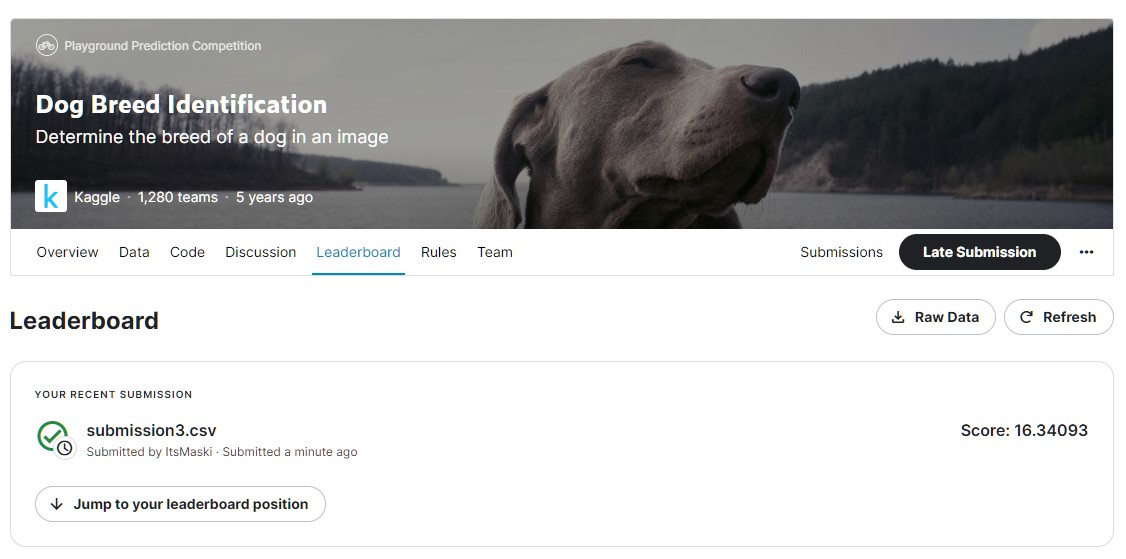

## **7. Hints to Improve Your Results**
- Try to increase the batch size and the number of epochs.
- Try deeper ResNet networks.


**Increased to 500 epochs (Started training from 100 epochs model)**
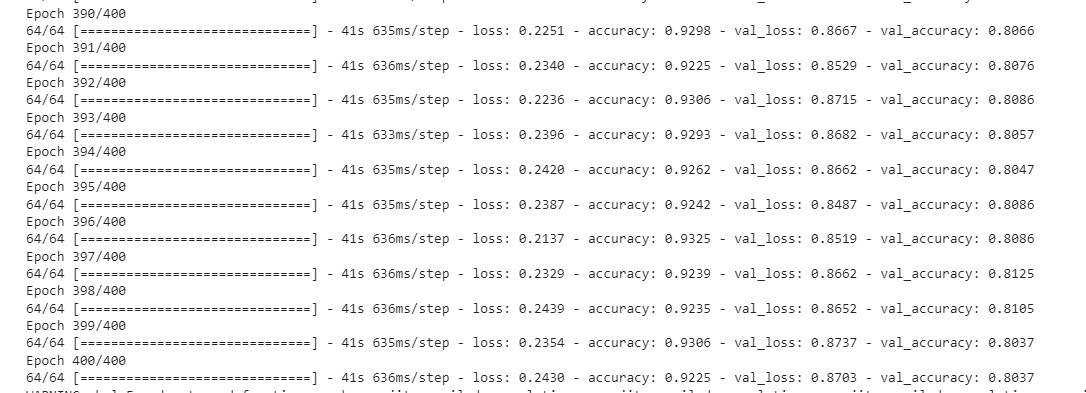